# Futures Calendar Spread

Pairing up futures contracts with different maturities creates what is known as calendar spread. One would think that calendar spreads offer good opportunities for mean reversion trading, but in reality they do not generally mean-revert. 

The fact that futures contracts with different maturities have different prices implies that a futures position will have nonzero return even if the underlying spot price remains unchanged, since eventually all their prices converge toward the spot price. This return is known as roll yield: 
* Backwardation (+ roll yield): the near contracts have higher prices than the far contracts. 
* Contango (- roll yield): opposite

Sometimes the relationship between futures contracts are models as: log futures prices with different maturities conform to the same linear function of time with the same slope but with different offsets, intersecting the spot price at expiration. However, real log futures prices are not linear function of time, they may even intersect (trade at the same price) before they expire, and the spot price at expiration is unlikely to be constant throughout time. 



In [122]:
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import pandas as pd

To calculate the spot and roll returns for a set of futures contracts, it is helpful to have a simple model of futures prices. For many commodities we can write: 

$$ F(t, T) = S(t) \exp{(\gamma (t-T))} $$
where $t$ is the current time, $T$ is the expiration date, and $S(t)$ is the spot price. This model implies that the (compounded) roll yield $\gamma$ is constant over time. 
We can take this further, and assume that the (compounded) spot return $\alpha$ is also constant
$$ S(t)=c e^{\alpha t} $$
This gives us the model
$$ F(t, T) = c e^{\alpha t} \exp{(\gamma (t-T))} $$
where $c,\alpha, \gamma$ are constants. The total return of a contract is given by
$$ \partial (\log{F(t, T)})/\partial t = \alpha + \gamma $$
since $T$ is fixed for a specific contract. The roll return of the futures contract is given by 
$$ - \partial (\log{F(t, T)})/\partial T = \gamma $$
Hence, we have captured the notion that total return = spot return + roll return. 

Based on this model we can use linear regression to estimate the spot and roll return of a futures series. We do this under the assumption that spot and roll returns ar constant throughout time. 
We find the spot return by regressing the log of the spot prices against time. 
The roll return requires us to pick a fixed point in time, and regress the prices of the various contracts against their time to maturity. In practice the regression coefficient will depend on that fixed time, and also on the exact set of contracts available at that time. We will therefore still end up with a slowly varying estimated $\gamma$. 


First we get the price of the futures contracts and the spot

In [247]:
futures_contracts = ['NGF24.NYM', 'NGG24.NYM', 'NGH24.NYM', 'NGJ24.NYM', 'NGK24.NYM', 'NGM24.NYM', 'NGN24.NYM', 'NGQ24.NYM', 'NGU24.NYM', 'NGV24.NYM', 'NGX24.NYM', 'NGZ24.NYM', 'NGF25.NYM', 'NGG25.NYM', 'NGH25.NYM', 'NGJ25.NYM', 'NGK25.NYM', 'NGM25.NYM', 'NGN25.NYM', 'NGQ25.NYM', 'NGU25.NYM', 'NGV25.NYM', 'NGX25.NYM', 'NGZ25.NYM']
spot_contract = 'NG=F'
period = '3y'
interval = '1d'

In [248]:
futures_prices = [yf.Ticker(t).history(period=period, interval=interval)['Close'] for t in futures_contracts]

<AxesSubplot: xlabel='Date'>

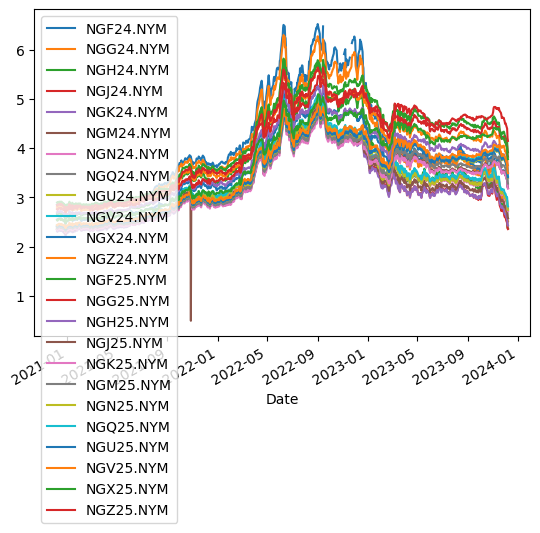

In [249]:
futures_prices_df = pd.concat(futures_prices, axis=1, keys=futures_contracts)
futures_prices_df.plot()

<AxesSubplot: xlabel='Date'>

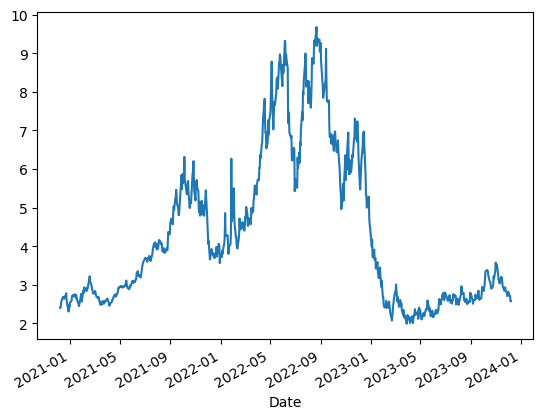

In [250]:
spot_price = yf.Ticker(spot_contract).history(period=period, interval=interval)['Close']
spot_price.plot()

We find the average annualized (compounded) spot return with a regression

<AxesSubplot: xlabel='Date'>

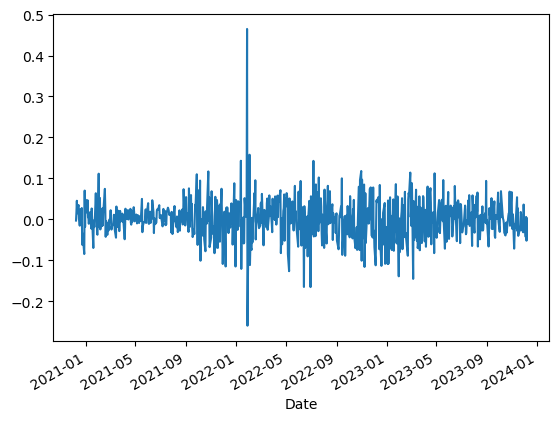

In [286]:
daily_returns = spot_price.pct_change().dropna()
daily_returns.plot()

In [287]:
T = np.arange(1, len(daily_returns) + 1)

In [288]:
X = sm.add_constant(T)
y = np.log(1+daily_returns)
model = sm.OLS(y, X)
results = model.fit()

In [289]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.381
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.240
Time:                        17:18:14   Log-Likelihood:                 1214.4
No. Observations:                 756   AIC:                            -2425.
Df Residuals:                     754   BIC:                            -2415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.004      1.043      0.2

Calculate the average annualized return using the geometric mean, by extracting the regression coefficient for time and adjusting for 252 trading days in a year

In [290]:
beta = results.params[1]
average_annualized_return = (1 + beta)**252 - 1  
print("Average Annualized Return:", average_annualized_return)

Average Annualized Return: -0.002396013083591275


We now calculate the gamma values by regressing futures prices

In [291]:
gamma = np.full(futures_prices_df.index.shape[0], np.nan)

In [292]:
for t in range(len(gamma)):
    FT = futures_prices_df.iloc[t, :].values
    idx = np.where(np.isfinite(FT))[0]
    
    idx_diff = np.diff(np.append(idx, [idx[-1] + 1]))  # Calculate differences with one additional element
    idx_diff_shifted = np.roll(idx_diff, 1)
    
    # Ensure consecutive months futures
    if len(idx) >= 5 and np.all(idx_diff_shifted[1:5] == 1):
        FT = FT[idx[:5]]
        T = np.arange(1, len(FT) + 1)
        
        # Perform linear regression
        X = sm.add_constant(T)
        y = np.log(FT)
        model = sm.OLS(y, X)
        results = model.fit()
        
        # Extract the regression coefficient for time
        gamma[t] = -12 * results.params[1]


Gamma now contains the values calculated in the loop

<AxesSubplot: xlabel='Date'>

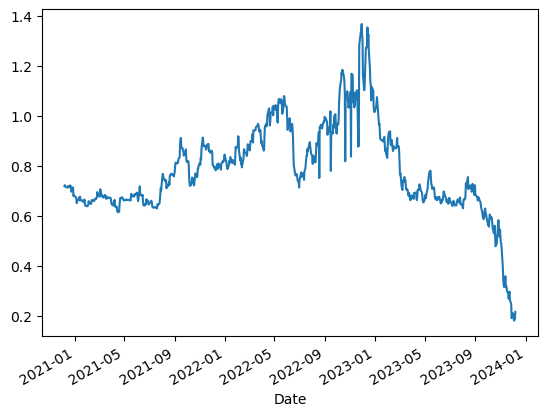

In [293]:
gamma = pd.Series(gamma, index=futures_prices_df.index, name='Gamma')
gamma.plot()

## Futures calendar spread mean reversion

A calendar spread is a portfolio that consists of a long position in one futures contract, and a short position in another futures contract with the same underlying but a different expiration month. However, this process is complicated due to roll returns. 


Calculate deltaGamma

<AxesSubplot: xlabel='Date'>

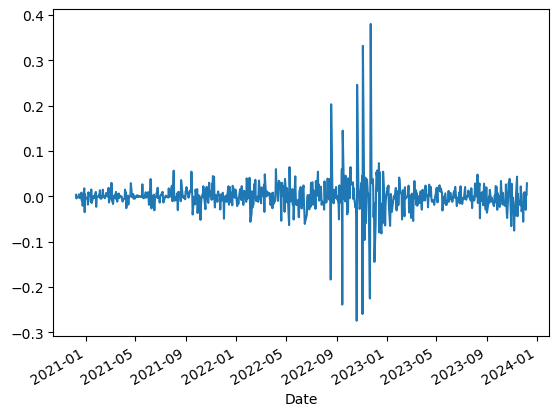

In [294]:
gamma_lag = gamma.shift().dropna()
delta_gamma = gamma.diff().dropna()
delta_gamma.plot()

Perform linear regression

In [295]:
X = sm.add_constant(gamma_lag)
y = delta_gamma
model = sm.OLS(y, X)
results = model.fit()

Calculate half-life

In [296]:
halflife = round(-np.log(2) / results.params[1])
print(f"Half-life: {halflife}")

Half-life: 49


We now need to calculate the Z-score with the lookback set equal to the half-life

<AxesSubplot: xlabel='Date'>

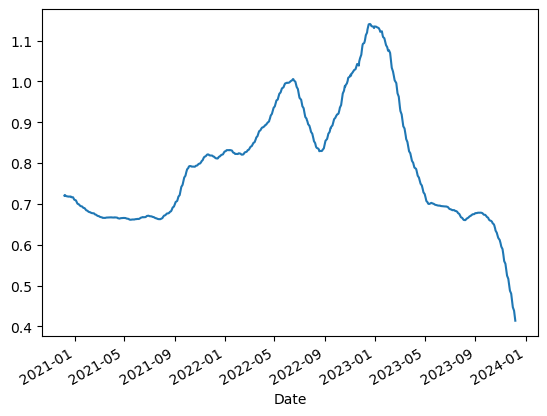

In [297]:
ma = gamma.rolling(window=halflife, min_periods=1).mean()
ma.plot()

<AxesSubplot: xlabel='Date'>

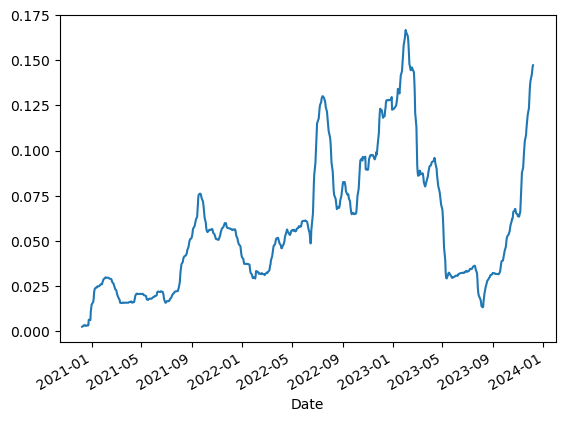

In [298]:
mstd = gamma.rolling(window=halflife, min_periods=1).std()
mstd.plot()

<AxesSubplot: xlabel='Date'>

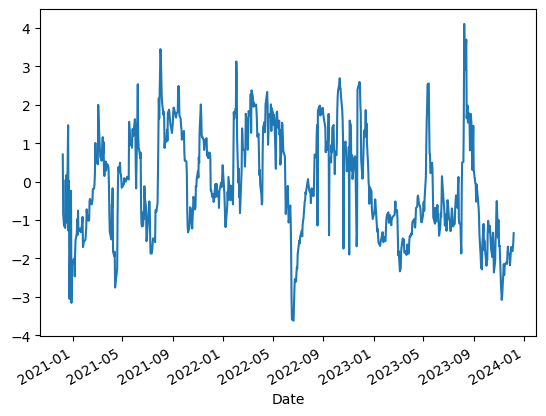

In [299]:
z_score = (gamma - ma) / mstd
z_score.plot()

Now we need to pick a pair of contracts, far and near, on each historical day, based on three criteria: 
1. The holding period for a pair of contracts is 3 monthhs (61 trading days). 
2. We roll forward to the next pair of contracts 10 days before the current near contract's expiration. 
3. The expiration dates of the near and far contracts are 1 year apart. 


We will hold a long position in the far contract, and a short position in the near one. 

In [307]:
is_expire_date = np.full(futures_prices_df.shape, False)
positions = np.zeros_like(futures_prices_df)
spreadMonth, holddays = 12, 3*21
numDaysStart=holddays+10
numDaysEnd=10

for c in range(len(futures_prices_df.columns) - spreadMonth): 
    expire_idx = np.where(np.isfinite(futures_prices_df.iloc[:, c]) & ~np.isfinite(np.roll(futures_prices_df.iloc[:, c], 1)))[0]
    
    if expire_idx.size > 0:
        expire_idx = expire_idx[-1]

        if c == 0:
            start_idx = max(1, expire_idx-numDaysStart)
            end_idx = expire_idx - numDaysEnd
        else:
            my_start_idx = end_idx + 1
            my_end_idx = expire_idx - numDaysEnd

            if my_end_idx - my_start_idx >= holddays:
                start_idx = my_start_idx
                end_idx = my_end_idx
            else:
                start_idx = np.nan

        if not np.isnan(expire_idx) and end_idx > start_idx:
            positions[start_idx:end_idx, c] = -1
            positions[start_idx:end_idx, c + spreadMonth] = 1

Display the resulting positions

<AxesSubplot: >

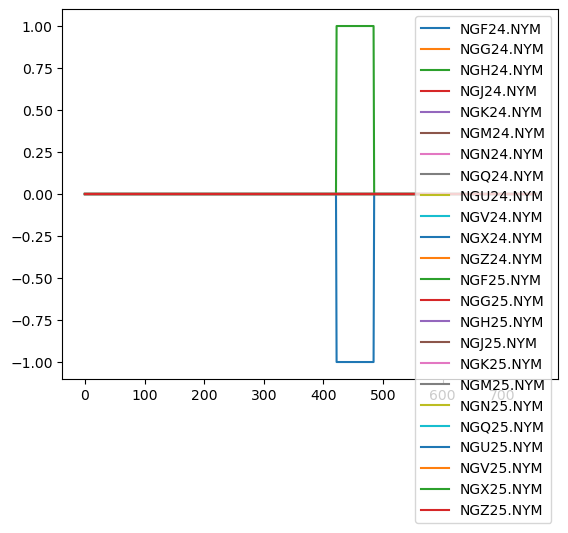

In [308]:
positions = pd.DataFrame(positions, columns=futures_prices_df.columns)
positions.plot()

Adjust positions based on zScore

<AxesSubplot: >

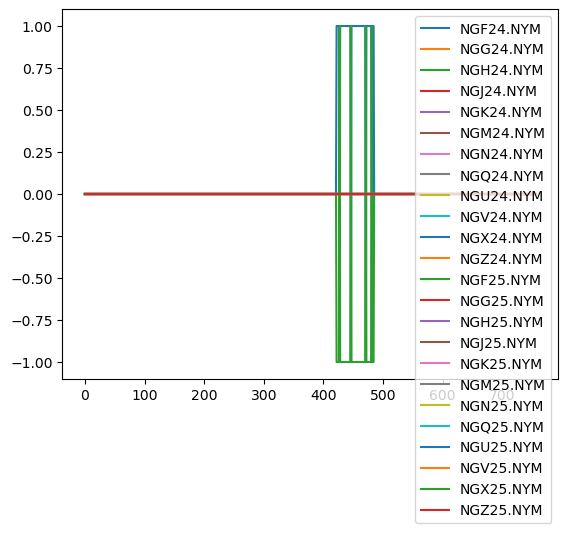

In [310]:
positions.values[z_score > 0] = -positions.values[z_score > 0]
positions.plot()

Calculate and plot returns

In [338]:
l=20
ret = np.nan_to_num(np.sum(positions.shift().values * (futures_prices_df - futures_prices_df.shift(l)) / futures_prices_df.shift(l).values, axis=1) / 2)

<AxesSubplot: xlabel='Date'>

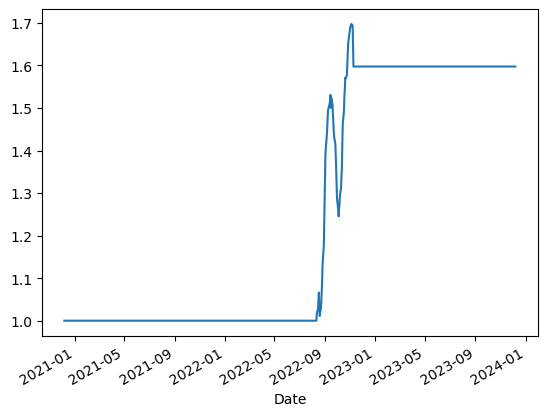

In [339]:
pd.Series(ret, index=futures_prices_df.index).add(1).cumprod().plot()